In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
from fast_tsne import fast_tsne

sys.path.append('Modules')

import rnaseqTools
import file_navigation
import read_data

color_dict = file_navigation.get_color_dict()

In [10]:
def get_reductions(df):
    fname = 'Mapping/MarkerGenes/Harris_Genes.txt'
    with open(fname) as f:
        genes = [line.split()[0] for line in f]
    
    df_reduction = df.loc[:,genes].copy()
    
    return df_reduction

def get_data():
    df_tpm = read_data.read_labeled_tpm_data('GSE99888')
    df_nbtsne = read_data.read_labeled_embedding_data('GSE99888')
    
    df_nbtsne = df_nbtsne.loc[df_tpm.columns,:].copy()
    df_tpm = df_tpm.T
    
    df_tpm = get_reductions(df_tpm)
    
    return df_nbtsne, df_tpm

def get_embeddings(df_pca):
    """
    given a dataframe, generate the 2-dimensional embeddings for it
    """
    
    # Step 0: Initialize variables
    columns = ['Plot_X', 'Plot_Y']
    
    # Step 2: Calculate embeddings
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    datalist = tsne.fit_transform(df_pca.values)
    df_tsne = pd.DataFrame(datalist, index=df_pca.index, columns=columns)
    
    reducer = umap.UMAP(n_components=2, n_neighbors=30, min_dist=.75, random_state=42, metric='euclidean')
    datalist = reducer.fit_transform(df_pca.values)
    df_umap = pd.DataFrame(datalist, index=df_pca.index, columns=columns)
    
    datalist = fast_tsne(df_pca.values, perplexity_list = [30,int(df_pca.shape[0]/100)],
                            learning_rate = df_pca.shape[0]/12, knn_algo='vp-tree', seed=42)
    df_fit = pd.DataFrame(datalist, index=df_pca.index, columns=columns)
    
    
    return df_tsne, df_umap, df_fit

def plot_embedding(ax, df, colors, title):
    ax.set_title(title, fontsize=12)
    ax.set_xticks([]), ax.set_yticks([])
    ax.scatter(df.Plot_X, df.Plot_Y, color=colors, s=1, alpha=.25)
    
    return

def read_in_dataset(dataset):
    params = {'sep':'\t', 'header':0, 'index_col':0}
    fname = 'Datasets/%s-tpm.tsv' % dataset
    df = pd.read_csv(fname, **params)
    
    return df

def generate_subset_data(dataset, embedding_title, save_title, continents):
    df = read_in_dataset(dataset)
    df_embed = read_data.read_labeled_embedding_data(embedding_title)
    fname = 'References/Harris_Continents.txt'
    df_continent = pd.read_csv(fname, sep='\t', header=0, index_col=0)
    df_continent = df_continent.loc[df_continent.Continent.isin(continents),:]
    
    df_zoom = df_embed.loc[df_embed.index.get_level_values('CellType').isin(df_continent.index),:]
    df = df.loc[:,df_zoom.index.get_level_values('Cell')]
    
    low_val = df_zoom.quantile(.02)
    high_val = df_zoom.quantile(.98)
    step = .05 * (high_val - low_val)
    low_val = low_val - step
    high_val = high_val + step
    
    keep_vars = np.array([np.logical_and(data>low, data<high)
                          for data, low, high
                          in zip(df_embed.values.T, low_val, high_val)
                         ]
                        )
    keep = keep_vars.sum(axis=0) == keep_vars.shape[0]
    
    df_embed = df_embed.loc[keep,:]
    
    df.to_csv('Mapping/DataSubsets/%s.tsv' % save_title, sep='\t')
    df_embed.to_csv('Mapping/DataSubsets/%s-embedding.tsv' % save_title, sep='\t')
    
    return

In [3]:
%%time

df_nbtsne, df_tpm = get_data()

CPU times: user 29.8 s, sys: 862 ms, total: 30.7 s
Wall time: 30.7 s


In [4]:
%%time

pca = PCA(n_components=50)

# Step 1: Normalize the data
datalist = np.log2(1+df_tpm.values)
datalist = pca.fit_transform(datalist)

df_pca = pd.DataFrame(datalist, index=df_tpm.index)

CPU times: user 583 ms, sys: 448 ms, total: 1.03 s
Wall time: 105 ms


In [5]:
%%time

df_tsne, df_umap, df_fit = get_embeddings(df_pca)

/home/soma/anaconda3/envs/analyze/lib/python3.6/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../../../anaconda3/envs/analyze/lib/python3.6/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/home/soma/anaconda3/envs/analyze/lib/python3.6/site-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../../../../anaconda3/envs/analyze/lib/python3.6/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  state.func_ir.loc))
/home/soma/anaconda3/envs/analyze/lib/p

CPU times: user 45.5 s, sys: 2.89 s, total: 48.4 s
Wall time: 1min 31s


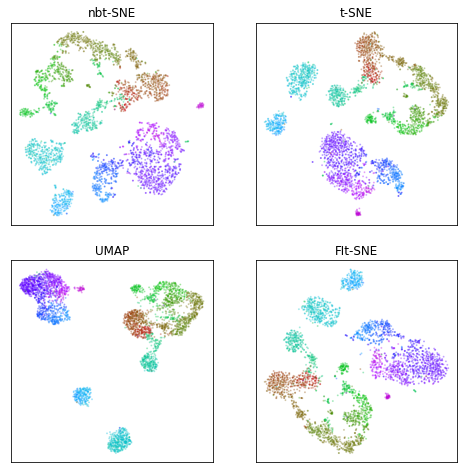

CPU times: user 4.45 s, sys: 799 ms, total: 5.25 s
Wall time: 3.86 s


In [6]:
%%time

colors = df_tpm.index.get_level_values('CellType').map(color_dict)
fig = plt.figure(figsize=(8.5,11))

ax = fig.add_axes([.15, .63, .33, .255])
plot_embedding(ax, df_nbtsne, colors, 'nbt-SNE')

ax = fig.add_axes([.55, .63, .33, .255])
plot_embedding(ax, df_tsne, colors, 't-SNE')

ax = fig.add_axes([.15, .33, .33, .255])
plot_embedding(ax, df_umap, colors, 'UMAP')

ax = fig.add_axes([.55, .33, .33, .255])
plot_embedding(ax, df_fit, colors, 'FIt-SNE')

fig.savefig('Mapping/Plots/Embedding_Plots_2.pdf')
plt.show()

In [7]:
%%time

df_tsne.to_csv('Mapping/Embeddings/Harris_tSNE.tsv', sep='\t')
df_umap.to_csv('Mapping/Embeddings/Harris_UMAP.tsv', sep='\t')
df_fit.to_csv('Mapping/Embeddings/Harris_FIt_tSNE.tsv', sep='\t')

CPU times: user 133 ms, sys: 8.08 ms, total: 141 ms
Wall time: 141 ms


In [11]:
%%time

generate_subset_data('GSE99888', 'GSE99888', 'Harris_Pvalb', [2,3])

CPU times: user 43.6 s, sys: 364 ms, total: 44 s
Wall time: 44 s
